In [1]:
import math
from scipy import io
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# calculate F/F0

def calc_dF (input):
    input = input - min(input)
    low_pc, high_pc = np.percentile(input, [10, 70])
    filter_arr = np.logical_and(np.greater(input, low_pc), np.less(input, high_pc))
    F0 = np.median(input[filter_arr])
    dF = (input - F0) / F0
    
    return dF

In [3]:
# load data and stimuli files

#F_all = io.loadmat('./suite2p/plane0/Fall.mat')
F = np.load('./suite2p/plane0/F.npy') #F_all["F"]
F_neu = np.load('./suite2p/plane0/Fneu.npy') #F_all["Fneu"]

out_dat = io.loadmat('./stimulus_files/noise80_5perc_omit_outDat_2021_3_12_13_43_29.mat')["outDat"]
trial_order = [val[0] for val in out_dat["trialOrder"][0][0]]

In [4]:
# convert raw fluorescence into deltaF/F

dF = []
for i in range(len(F)):
    dF.append( calc_dF(F[i, :] - 0.7*F_neu[i, :]) )
dF = np.array(dF)

In [5]:
# reshape raw data into format (n_ROIs, 30_frames, n_trials)
# and order into stimuli and omission trials

n_trials = len(trial_order)
n_ROIs = len(dF)
trials_raw = np.reshape(dF[:, :32400], (n_ROIs, 30, n_trials), order='f')

sorted_idxs = [i[0] for i in sorted(enumerate(trial_order), key=lambda x:x[1])]
trials_ordered = trials_raw[:, :, sorted_idxs]

trials_stimuli = trials_ordered[:, :, :1026]
trials_omission = trials_ordered[:, :, 1026:]

Text(0, 0.5, 'dF/F')

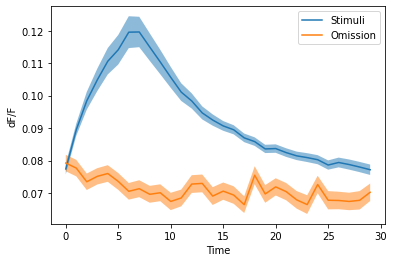

In [12]:
mean_trials_stimuli = np.mean(trials_stimuli, axis=2)
mean_trials_omission = np.mean(trials_omission, axis=2)

roi_stim_mean = np.mean(mean_trials_stimuli, axis=0)
roi_stim_stderr = np.std(mean_trials_stimuli, axis=0) / math.sqrt(len(mean_trials_stimuli))

roi_omis_mean = np.mean(mean_trials_omission, axis=0)
roi_omis_stderr = np.std(mean_trials_omission, axis=0) / math.sqrt(len(mean_trials_omission))

plt.plot(roi_stim_mean, label='Stimuli')
plt.fill_between(np.arange(30), roi_stim_mean+roi_stim_stderr, roi_stim_mean-roi_stim_stderr, alpha=0.5)
plt.plot(roi_omis_mean, label='Omission')
plt.fill_between(np.arange(30), roi_omis_mean+roi_omis_stderr, roi_omis_mean-roi_omis_stderr, alpha=0.5)

plt.legend()
plt.xlabel('Time')
plt.ylabel('dF/F')